## Natural Language Processing (ft. Spotify) 
Carthage Guest Lecture

Benjamin Burch

2024-03-23

Before you start, create a Kaggle account at kaggle.com to download the Spotify data set

Create an API key at https://www.kaggle.com/settings

Place the downloaded kaggle.json file in C:/Users/\<windows user name\>/.kaggle

Set up your Python environment

```
py -m venv ./env
env/Scripts/activate
py -m pip install -U pip wheel setuptools
py -m pip install ipykernel gensim nltk spacy seaborn plotly pandas bertopic kaggle
python -m spacy download en_core_web_lg
```
Download the Spotify Million Song data set https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset/data

``` !kaggle datasets download -d notshrirang/spotify-million-song-dataset```

Make sure to unzip spotify-million-song-dataset.zip into your project folder

# What is Natural Language Processing?

<div>
<img src="./figures/nlp.png" width="800"/>
</div>

# A Brief History of NLP

<div>
<img src="./figures/nlp_history.png" width="800"/>
</div>

In [259]:
# python sys libraries
import os
import re
import pickle
import itertools
from collections import Counter
from datetime import datetime
import time

#standard DS libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

#nlp libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import gensim.models as w2v
from openai import AzureOpenAI #need API key
import openai

#plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

#topic modeling
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import OpenAI
from sklearn.feature_extraction.text import CountVectorizer



#additional setup
from dotenv import load_dotenv
pd.options.display.float_format = '{:,.2f}'.format
_=load_dotenv()
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bpburch\AppData\Roaming\nltk_data...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bpburch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
songs = pd.read_csv('./spotify-million-song-dataset/spotify_millsongdata.csv')

In [3]:
songs.shape

(57650, 4)

In [4]:
songs.head()

artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \r\nA...  
1  Take it easy with me, please  \r\nTouch me gen...  
2  I'll never know why I had to go  \r\nWhy I had...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...

<Axes: title={'center': 'Top Artists by Song Count'}, ylabel='artist'>

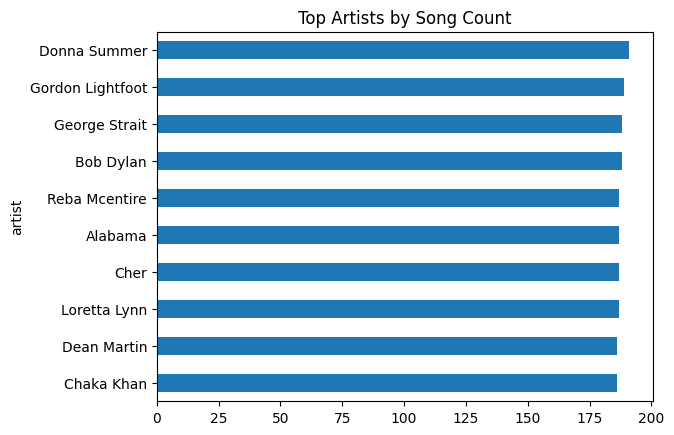

In [5]:
songs.artist.value_counts().head(10).sort_values().plot(kind='barh',title='Top Artists by Song Count' )

In [6]:
print(songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].text.values[0])

We're no strangers to love  
You know the rules and so do I  
A full commitment's what I'm thinking of  
You wouldn't get this from any other guy  
  
I just want to tell you how I'm feeling  
Gotta make you understand  
  
[Chorus:]  
Never gonna give you up, never gonna let you down  
Never gonna run around and desert you  
Never gonna make you cry, never gonna say goodbye  
Never gonna tell a lie and hurt you  
  
We've known each other for so long  
Your heart's been aching but you're too shy to say it  
Inside we both know what's been going on  
We know the game and we're gonna play it  
  
And if you ask me how I'm feeling  
Don't tell me you're too blind to see  
  
[Chorus x2]  
Never gonna give you up, never gonna let you down  
Never gonna run around and desert you  
Never gonna make you cry, never gonna say goodbye  
Never gonna tell a lie and hurt you  
  
(Ooh give you up)  
(Ooh give you up)  
(Ooh) Never gonna give, never gonna give (give you up)  
(Ooh) Never gonna give

In [7]:
songs['tokens']=songs.text.apply(str.split)

In [8]:
all_tokens = list(itertools.chain.from_iterable(songs['tokens']))

In [9]:
print(f"There are {len(all_tokens):,} total tokens!")
print(f"There are {len(set(all_tokens)):,} distinct tokens!")

There are 12,653,383 total tokens!
There are 210,321 distinct tokens!


In [10]:
token_counts = Counter(all_tokens)
token_counts_df = pd.DataFrame.from_dict(token_counts, orient='index',columns=['count']).reset_index().rename(columns={"index":"token"}).sort_values('count', ascending=False)

In [11]:
print(token_counts_df)

              token   count
15              the  446872
49                I  415921
101             you  326267
13               to  273065
5                 a  235203
...             ...     ...
118074  money-maker       1
118070         GTO,       1
118065      turnin4       1
118064      Cranked       1
210320       titans       1

[210321 rows x 2 columns]


Text(0.5, 1.0, 'The top words are really boring')

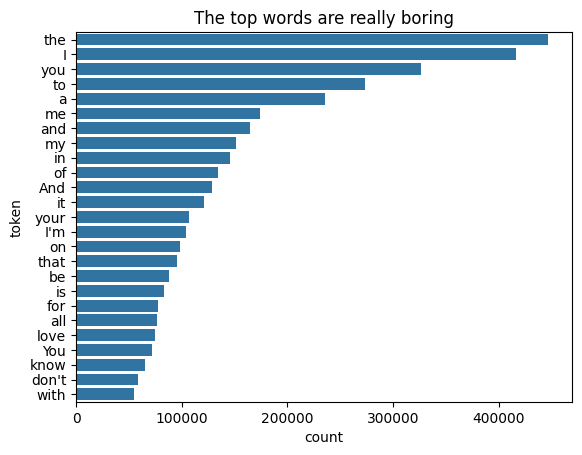

In [12]:
sns.barplot(token_counts_df.head(25), x='count', y='token').set_title('The top words are really boring')

Text(0.5, 1.0, 'The rare words are really weird')

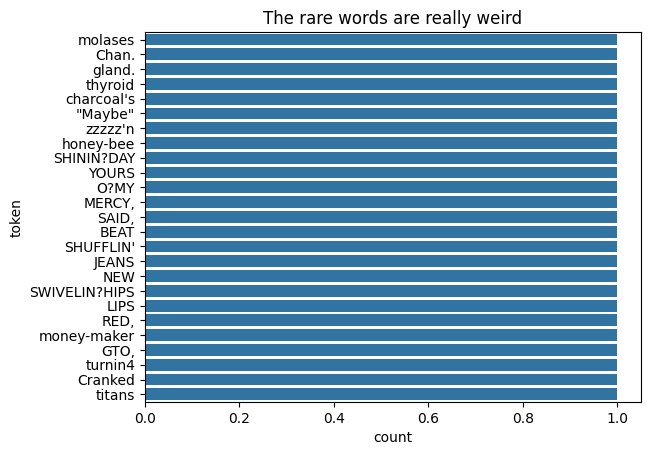

In [13]:
sns.barplot(token_counts_df.tail(25), x='count', y='token').set_title('The rare words are really weird')

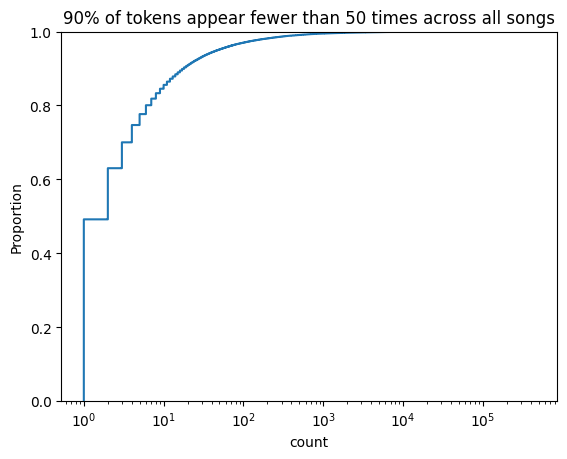

In [14]:
p = sns.ecdfplot(token_counts_df['count'], stat='proportion', log_scale=True).set_title("90% of tokens appear fewer than 50 times across all songs")

### Let's clean this up

1. lowercase everything
2. remove punctuation
3. stemming and lemmatization?
4. remove "stop words"

https://docs.cohere.com/docs/text-pre-processing-in-nlp

https://www.codecademy.com/learn/dsnlp-text-preprocessing/modules/nlp-text-preprocessing/cheatsheet

## 1. Lowercase it all!

In [15]:
songs['text_lower'] = songs['text'].apply(str.lower)
songs[['text','text_lower']].head()

text  \
0  Look at her face, it's a wonderful face  \r\nA...   
1  Take it easy with me, please  \r\nTouch me gen...   
2  I'll never know why I had to go  \r\nWhy I had...   
3  Making somebody happy is a question of give an...   
4  Making somebody happy is a question of give an...   

                                          text_lower  
0  look at her face, it's a wonderful face  \r\na...  
1  take it easy with me, please  \r\ntouch me gen...  
2  i'll never know why i had to go  \r\nwhy i had...  
3  making somebody happy is a question of give an...  
4  making somebody happy is a question of give an...

## 2. Remove (most) punctuation!

In [140]:
def clean_lyrics(lyrics):
    # Define the pattern to keep apostrophes in contractions and hyphens in compound words
    # Remove other common punctuation
    cleaned_lyrics = re.sub(r"[,\.!?;:()\"\\\/\[\]]", "", lyrics)
    
    # Remove extra whitespace
    cleaned_lyrics = re.sub(r"\s+", " ", cleaned_lyrics).strip()
    
    #truncate tokens at apostrophes
    cleaned_lyrics = ' '.join([token.split("'")[0] for token in cleaned_lyrics.split()])
    
    cleaned_lyrics=' '.join([token for token in cleaned_lyrics.split() if not any(char.isdigit() for char in token)])
        
    return cleaned_lyrics

In [141]:
songs['text_lower_rempunct'] = songs['text_lower'].apply(clean_lyrics)
songs[['text','text_lower_rempunct']].head(10)

text  \
0  Look at her face, it's a wonderful face  \r\nA...   
1  Take it easy with me, please  \r\nTouch me gen...   
2  I'll never know why I had to go  \r\nWhy I had...   
3  Making somebody happy is a question of give an...   
4  Making somebody happy is a question of give an...   
5  Well, you hoot and you holler and you make me ...   
6  Down in the street they're all singing and sho...   
7  Chiquitita, tell me what's wrong  \r\nYou're e...   
8  I was out with the morning sun  \r\nCouldn't s...   
9  I'm waitin' for you baby  \r\nI'm sitting all ...   

                                 text_lower_rempunct  
0  look at her face it a wonderful face and it me...  
1  take it easy with me please touch me gently li...  
2  i never know why i had to go why i had to put ...  
3  making somebody happy is a question of give an...  
4  making somebody happy is a question of give an...  
5  well you hoot and you holler and you make me m...  
6  down in the street they all singing and shouti...  
7  chiquitita tell me what wrong you enchained by...  
8  i was out with the morning sun couldn sleep so...  
9  i waitin for you baby i sitting all alone i fe...

In [142]:
def plot_top_tokens_from_lyrics(lyrics, topn=20, ax=None, title=None):
    all_tokens = list(itertools.chain.from_iterable(lyrics.apply(str.split)))
    token_counts = Counter(all_tokens)
    token_counts_df = pd.DataFrame.from_dict(token_counts, orient='index',columns=['count']).reset_index().rename(columns={"index":"token"}).sort_values('count', ascending=False)    
    sns.barplot(token_counts_df.head(topn), x='count', y='token',ax=ax).set_title(title)

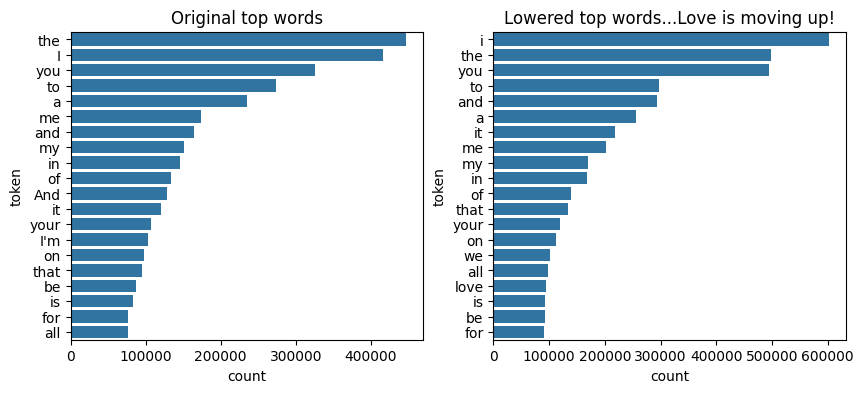

In [143]:
topn=20

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
sns.barplot(token_counts_df.head(topn), x='count', y='token', ax=ax1).set_title('Original top words')
plot_top_tokens_from_lyrics(songs.text_lower_rempunct, topn=topn, ax=ax2, title='Lowered top words...Love is moving up!')


### 3. Stemming vs. lemmatization

<div>
<img src="./figures/stemming_vs_lemmatization.png" width="800"/>
</div>

In [144]:
lemmatizer = WordNetLemmatizer()

def lemmatize(lyric):
    lemmatized_lyric = ' '.join([lemmatizer.lemmatize(token) for token in lyric.split()])
    
    return lemmatized_lyric

songs['text_lower_rempunct_lemma'] = songs['text_lower_rempunct'].apply(lemmatize)
songs[['text','text_lower_rempunct_lemma']].head(10)

text  \
0  Look at her face, it's a wonderful face  \r\nA...   
1  Take it easy with me, please  \r\nTouch me gen...   
2  I'll never know why I had to go  \r\nWhy I had...   
3  Making somebody happy is a question of give an...   
4  Making somebody happy is a question of give an...   
5  Well, you hoot and you holler and you make me ...   
6  Down in the street they're all singing and sho...   
7  Chiquitita, tell me what's wrong  \r\nYou're e...   
8  I was out with the morning sun  \r\nCouldn't s...   
9  I'm waitin' for you baby  \r\nI'm sitting all ...   

                           text_lower_rempunct_lemma  
0  look at her face it a wonderful face and it me...  
1  take it easy with me please touch me gently li...  
2  i never know why i had to go why i had to put ...  
3  making somebody happy is a question of give an...  
4  making somebody happy is a question of give an...  
5  well you hoot and you holler and you make me m...  
6  down in the street they all singing and shouti...  
7  chiquitita tell me what wrong you enchained by...  
8  i wa out with the morning sun couldn sleep so ...  
9  i waitin for you baby i sitting all alone i fe...

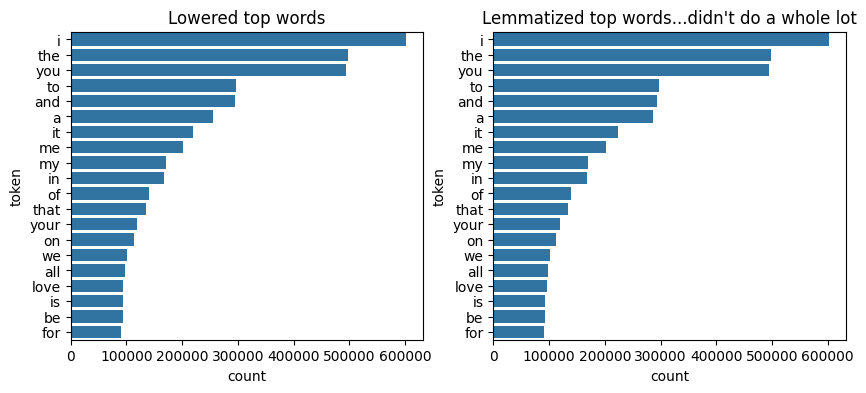

In [153]:
topn=20

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
plot_top_tokens_from_lyrics(songs.text_lower_rempunct, topn=topn, ax=ax1, title='Lowered top words')
plot_top_tokens_from_lyrics(songs.text_lower_rempunct_lemma, topn=topn, ax=ax2, title="Lemmatized top words...didn't do a whole lot")

### 4. Remove Stop Words

Stop word are common word that do not add significant meaning to the text you are working with. 

Your stop words may be different for different use cases!

**THIS IS AN ITERATIVE PROCESS!!!**

<div>
<img src="./figures/stop_words.png" width="300"/>
</div>

In [146]:
stop_words = set(stopwords.words('english')) 
sorted(list(stop_words))[0:25]

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both']

In [147]:
def remove_stopwords(lyric, stop_word_list=stop_words):
    new_lyric = ' '.join([word for word in lyric.split() if word not in stop_word_list])
    return new_lyric

In [148]:
songs['text_lower_rempunct_lemma_nostop'] = songs['text_lower_rempunct_lemma'].apply(remove_stopwords)
songs[['text','text_lower_rempunct_lemma_nostop']].head(10)

text  \
0  Look at her face, it's a wonderful face  \r\nA...   
1  Take it easy with me, please  \r\nTouch me gen...   
2  I'll never know why I had to go  \r\nWhy I had...   
3  Making somebody happy is a question of give an...   
4  Making somebody happy is a question of give an...   
5  Well, you hoot and you holler and you make me ...   
6  Down in the street they're all singing and sho...   
7  Chiquitita, tell me what's wrong  \r\nYou're e...   
8  I was out with the morning sun  \r\nCouldn't s...   
9  I'm waitin' for you baby  \r\nI'm sitting all ...   

                    text_lower_rempunct_lemma_nostop  
0  look face wonderful face mean something specia...  
1  take easy please touch gently like summer even...  
2  never know go put lousy rotten show boy wa tou...  
3  making somebody happy question give take learn...  
4  making somebody happy question give take learn...  
5  well hoot holler make mad always heel holy chr...  
6  street singing shouting staying alive though c...  
7  chiquitita tell wrong enchained sorrow eye hop...  
8  wa morning sun sleep thought take walk wa thin...  
9  waitin baby sitting alone feel cold without ch...

In [149]:
songs['clean_tokens']=songs.text_lower_rempunct_lemma_nostop.apply(str.split)
clean_tokens = list(itertools.chain.from_iterable(songs['clean_tokens']))

In [150]:
print(f"There are {len(all_tokens):,} total raw tokens!")
print(f"There are {len(set(all_tokens)):,} distinct raw tokens!\n")
print(f"There are {len(clean_tokens):,} total clean tokens!")
print(f"There are {len(set(clean_tokens)):,} distinct clean tokens!")

There are 12,653,383 total raw tokens!
There are 210,321 distinct raw tokens!

There are 6,163,675 total clean tokens!
There are 88,341 distinct clean tokens!


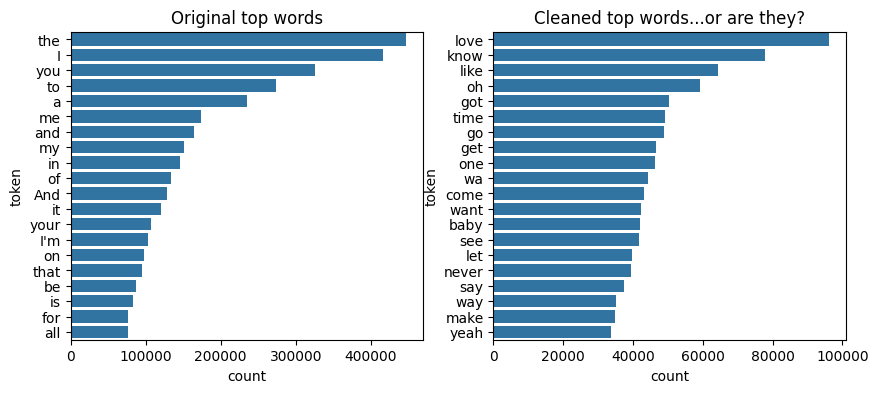

In [151]:
topn=20

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
sns.barplot(token_counts_df.head(topn), x='count', y='token', ax=ax1).set_title('Original top words')
plot_top_tokens_from_lyrics(songs.text_lower_rempunct_lemma_nostop, topn=topn, ax=ax2, title='Cleaned top words...or are they?')

In [154]:
print(f"{songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].text_lower_rempunct_lemma_nostop.values[0][0:96]} ...")
print('\nVS.\n')
print(f"{songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].text.values[0][0:225]}...")

stranger love know rule full commitment thinking get guy want tell feeling gotta make understand ...

VS.

We're no strangers to love  
You know the rules and so do I  
A full commitment's what I'm thinking of  
You wouldn't get this from any other guy  
  
I just want to tell you how I'm feeling  
Gotta make you understand ...


### Let's look at how many words we match.

In [155]:
never_gonna_give_you_tokens_raw = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].tokens.values[0]
never_gonna_give_you_tokens_clean = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].clean_tokens.values[0]

In [156]:
songs['astley_match_raw'] = songs.tokens.apply(lambda x: set(x) & set(never_gonna_give_you_tokens_raw))
songs['astley_match_clean'] = songs.tokens.apply(lambda x: set(x) & set(never_gonna_give_you_tokens_clean))

In [157]:
songs[['artist', 'song', 'text','astley_match_raw', 'astley_match_clean']].head(10)

artist                   song  \
0   ABBA  Ahe's My Kind Of Girl   
1   ABBA       Andante, Andante   
2   ABBA         As Good As New   
3   ABBA                   Bang   
4   ABBA       Bang-A-Boomerang   
5   ABBA     Burning My Bridges   
6   ABBA              Cassandra   
7   ABBA             Chiquitita   
8   ABBA            Crazy World   
9   ABBA        Crying Over You   

                                                text  \
0  Look at her face, it's a wonderful face  \r\nA...   
1  Take it easy with me, please  \r\nTouch me gen...   
2  I'll never know why I had to go  \r\nWhy I had...   
3  Making somebody happy is a question of give an...   
4  Making somebody happy is a question of give an...   
5  Well, you hoot and you holler and you make me ...   
6  Down in the street they're all singing and sho...   
7  Chiquitita, tell me what's wrong  \r\nYou're e...   
8  I was out with the morning sun  \r\nCouldn't s...   
9  I'm waitin' for you baby  \r\nI'm sitting all ...   

                                    astley_match_raw  \
0  {what, for, I, to, we, and, I'm, of, it, a, me...   
1  {I, and, make, And, feeling, you, you're, I'm,...   
2  {I, Gotta, and, make, get, And, love, you, I'm...   
3  {I, and, get, And, love, feeling, you, you're,...   
4  {I, and, get, And, love, feeling, you, you're,...   
5  {you, You, what, for, I, been, gonna, and, I'm...   
6  {from, I, and, And, you, you're, aching, I'm, ...   
7  {I, and, see, Your, And, you, you're, I'm, kno...   
8  {I, and, see, And, blind, feeling, you, know, ...   
9  {you, for, I, to, we, I'm, know, of, so, me, n...   

                                  astley_match_clean  
0                                                 {}  
1                   {feeling, know, make, play, let}  
2                     {know, get, make, never, love}  
3           {feeling, give, know, get, around, love}  
4           {feeling, give, know, get, around, love}  
5                                      {make, gonna}  
6                                     {aching, know}  
7                             {cry, tell, see, know}  
8  {feeling, tell, gonna, know, never, see, long,...  
9                                      {never, know}

In [158]:
songs['astley_match_raw_length'] = songs['astley_match_raw'].apply(len)
songs['astley_match_clean_length'] = songs['astley_match_clean'].apply(len)

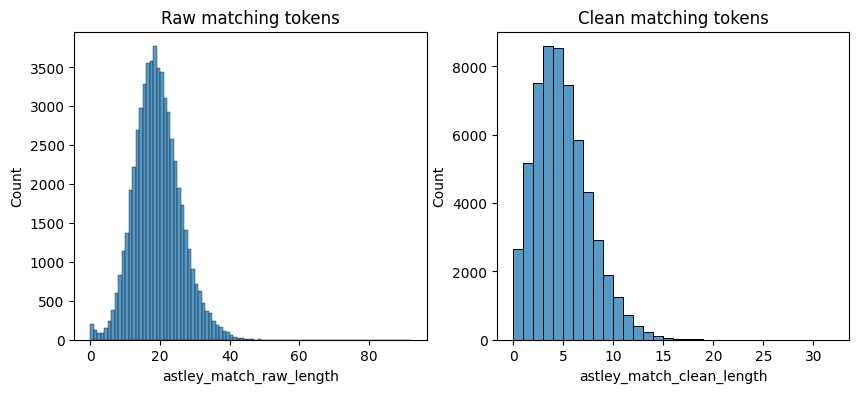

In [159]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
p=sns.histplot(songs.astley_match_raw_length, binwidth=1, ax=ax1).set_title('Raw matching tokens')
p=sns.histplot(songs.astley_match_clean_length, binwidth=1, ax=ax2).set_title('Clean matching tokens')


In [160]:
top10_raw = songs.sort_values('astley_match_raw_length', ascending=False)[['artist', 'song', 'text','astley_match_raw', 'astley_match_raw_length']].head(10)
top10_raw

artist                     song  \
50844  Rick Astley  Never Gonna Give You Up   
16477   Puff Daddy              Satisfy You   
51834   Snoop Dogg         I Believe In You   
43360    Mc Hammer              Crime Story   
8862        J Cole             Friday Night   
31411       Eminem                      Kim   
5076        Eminem                 Farewell   
30494        Drake           Poetic Justice   
11541    Lil Wayne        Breakin' My Heart   
41941    LL Cool J          Jack The Ripper   

                                                    text  \
50844  We're no strangers to love  \r\nYou know the r...   
16477  [Puffy]  \r\nAll I want is somebody who's gonn...   
51834  [Latoiya Williams]  \r\nI'm so glad that you b...   
43360  Crime stories  \r\nYou get, boy, no glory  \r\...   
8862   Yeah,  \r\nHey,  \r\nYeah,  \r\n  \r\nPartiall...   
31411  Aw look at daddy's baby girl  \r\nThat's daddy...   
5076   I don't wanna say goodbye  \r\nBut sometimes t...   
30494  Every second, every minute, man I swear that s...   
11541  (feat. Little Brother)  \r\n  \r\nHey baby loo...   
41941  Milky, and I'm back  \r\nMy ace in the hole wa...   

                                        astley_match_raw  \
50844  {wouldn't, heart's, I, hurt, see, say, you, yo...   
16477  {from, I, hurt, We, and, make, get, see, And, ...   
51834  {from, I, We, and, make, see, run, And, both, ...   
43360  {from, I, We, and, make, get, And, Your, love,...   
8862   {from, I, hurt, We, Gotta, and, make, get, see...   
31411  {from, I, We, and, make, get, see, run, And, b...   
5076   {wouldn't, from, I, We, and, get, see, And, lo...   
30494  {from, I, We, and, make, get, see, run, And, b...   
11541  {from, I, We, and, get, see, And, blind, love,...   
41941  {from, I, and, make, get, see, run, And, Your,...   

       astley_match_raw_length  
50844                       92  
16477                       48  
51834                       48  
43360                       47  
8862                        46  
31411                       46  
5076                        46  
30494                       45  
11541                       45  
41941                       45

In [161]:
top10_clean=songs.sort_values('astley_match_clean_length', ascending=False)[['artist', 'song', 'text','astley_match_clean', 'astley_match_clean_length']].head(10)
top10_clean

artist                     song  \
50844      Rick Astley  Never Gonna Give You Up   
11721    Lionel Richie              Do It To Me   
15288          Outkast                The Train   
16477       Puff Daddy              Satisfy You   
16731         R. Kelly           If I'm Wit You   
41941        LL Cool J          Jack The Ripper   
49206       Puff Daddy            I Hear Voices   
57104         Yelawolf              Throw It Up   
57251               YG              Do It To Ya   
57268  Ying Yang Twins                Long Time   

                                                    text  \
50844  We're no strangers to love  \r\nYou know the r...   
11721  Girl, you're such a bad thing  \r\nStanding th...   
15288  All aboard  \r\nOr are all y'all bored?  \r\nI...   
16477  [Puffy]  \r\nAll I want is somebody who's gonn...   
16731  I don't understand  \r\nI do all this for you ...   
41941  Milky, and I'm back  \r\nMy ace in the hole wa...   
49206  Sometimes I don't think you motherfuckers  \r\...   
57104  Aye boo get these motherfuckers and pass that ...   
57251  Annie, girl, let's play house  \r\nAnd you can...   
57268  Girl, Me and the Lods been friends for a might...   

                                      astley_match_clean  \
50844  {hurt, get, make, see, run, blind, love, feeli...   
11721  {heart, hurt, get, make, see, inside, cry, lov...   
15288  {heart, hurt, get, make, gotta, see, feeling, ...   
16477  {feeling, say, heart, game, give, hurt, gonna,...   
16731  {game, give, heart, hurt, gonna, understand, g...   
41941  {say, game, give, gonna, want, play, know, get...   
49206  {say, heart, tell, gonna, know, get, make, und...   
57104  {feeling, say, heart, game, hurt, tell, gonna,...   
57251  {say, give, hurt, tell, gonna, going, know, ma...   
57268  {feeling, game, heart, give, gonna, going, kno...   

       astley_match_clean_length  
50844                         32  
11721                         20  
15288                         19  
16477                         18  
16731                         18  
41941                         18  
49206                         18  
57104                         17  
57251                         17  
57268                         17

In [162]:
pd.concat([top10_raw[['artist', 'song']].reset_index(drop=True), top10_clean[['artist', 'song']].reset_index(drop=True)], axis=1)

artist                     song           artist  \
0  Rick Astley  Never Gonna Give You Up      Rick Astley   
1   Puff Daddy              Satisfy You    Lionel Richie   
2   Snoop Dogg         I Believe In You          Outkast   
3    Mc Hammer              Crime Story       Puff Daddy   
4       J Cole             Friday Night         R. Kelly   
5       Eminem                      Kim        LL Cool J   
6       Eminem                 Farewell       Puff Daddy   
7        Drake           Poetic Justice         Yelawolf   
8    Lil Wayne        Breakin' My Heart               YG   
9    LL Cool J          Jack The Ripper  Ying Yang Twins   

                      song  
0  Never Gonna Give You Up  
1              Do It To Me  
2                The Train  
3              Satisfy You  
4           If I'm Wit You  
5          Jack The Ripper  
6            I Hear Voices  
7              Throw It Up  
8              Do It To Ya  
9                Long Time

## Can we do better?

1. There were still a lot of noise words in there.
2. There could be misspellings (mispellings? ms. pellings?).
3. Lots of word are spelled differently but have similar meaning
4. Context matters!



<div>
<img src="./figures/classic_v_deep.png" width="800"/>
</div>

### ENTER WORD VECTORS TO SAVE THE DAY!

<div>
<img src="./figures/super_word_vector.png" width="400"/>
</div>

### One-hot encoding

1. The CURSE OF DIMENSIONALITY!!!!
2. So sparse!
3. Synonyms, antonyms
4. But where is the context?
5. Still doesn't fix the frequent word problem

<div>
<img src="./figures/word_bird.png" width="600"/>
</div>

### word2vec

<div>
<img src="./figures/word2vec.png" width="800"/>
</div>

<div>
<img src="./figures/w2v.jpg" width="800"/>
</div>

<div>
<img src="./figures/vector_relationships.png" width="800"/>
</div>

<div>
<img src="./figures/word_distribution.png" width="800"/>
</div>

<div>
<img src="./figures/newsgroup.png" width="500"/>
</div>

In [136]:
def remove_tokens_with_numbers(lines):
    # Function to check if the token contains any digit
    def has_number(token):
        return any(char.isdigit() for char in token)
    
    # Apply the function to filter out tokens with numbers from each line
    cleaned_lines = [' '.join([token for token in line.split() if not has_number(token)]) for line in lines]
    
    return cleaned_lines


In [ ]:
def has_number(token):
        return any(char.isdigit() for char in token)

In [137]:
def clean_for_w2v(text):
    text = text.lower().splitlines()
    text = [re.sub(r"[,\.!?;:()\"\\\/\[\]]", "", line) for line in text]
    text = [' '.join([token.split("'")[0] for token in line.split()]) for line in text]
    text = [' '.join([token for token in line.split() if not any(char.isdigit() for char in token)]) for line in text]
    text = [lemmatize(line) for line in text]
    text = [remove_stopwords(line) for line in text]
    text = [re.sub(r"\s+", " ", line).strip() for line in text]
    text = [line for line in text if len(line)>0]
    return text

In [138]:
songs['text_for_w2v'] = songs['text'].apply(clean_for_w2v)

In [139]:
songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')]['text_for_w2v'].values[0]

['stranger love',
 'know rule',
 'full commitment thinking',
 'get guy',
 'want tell feeling',
 'gotta make understand',
 'chorus',
 'never gonna give never gonna let',
 'never gonna run around desert',
 'never gonna make cry never gonna say goodbye',
 'never gonna tell lie hurt',
 'known long',
 'heart aching shy say',
 'inside know going',
 'know game gonna play',
 'ask feeling',
 'tell blind see',
 'chorus',
 'never gonna give never gonna let',
 'never gonna run around desert',
 'never gonna make cry never gonna say goodbye',
 'never gonna tell lie hurt',
 'ooh give',
 'ooh give',
 'ooh never gonna give never gonna give give',
 'ooh never gonna give never gonna give give',
 'known long',
 'heart aching shy say',
 'inside know going',
 'know game gonna play',
 'want tell feeling',
 'gotta make understand',
 'chorus',
 'never gonna give never gonna let',
 'never gonna run around desert',
 'never gonna make cry never gonna say goodbye',
 'never gonna tell lie hurt']

In [167]:
all_song_lines = list(itertools.chain.from_iterable(songs['text_for_w2v'].values))

In [168]:
len(all_song_lines)

1986905

In [171]:
print('median: ',np.median([len(line) for line in all_song_lines]))
print('mean: ',np.mean([len(line) for line in all_song_lines]))
print('longest song line: ',np.max([len(line) for line in all_song_lines]))

median:  16.0
mean:  17.137456999705574
longest song line:  105


In [177]:
class LossLogger(w2v.callbacks.CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        print(f'  Loss: {loss}')
        self.epoch += 1

In [214]:
loss_logger = LossLogger()
w2v_model =  w2v.Word2Vec([text.split() for text in all_song_lines], vector_size=300, window=7, min_count=5, workers=7, sg=0, epochs=3, compute_loss=True,callbacks=[loss_logger])

Epoch: 1	  Loss: 1957185.25
Epoch: 2	  Loss: 3664174.0
Epoch: 3	  Loss: 5068319.5


In [215]:
w2v_model.save('./model.w2v')

In [216]:
print(f"My model has a vocabulary of {len(w2v_model.wv.key_to_index):,} words")

My model has a vocabulary of 25,722 words


In [246]:
w2v_model.wv['love']

array([ 0.26422662,  0.4133058 , -0.03959124,  0.6481506 , -0.6577768 ,
       -1.2185487 , -0.32644472,  0.7764055 , -0.15692234, -0.0711055 ,
        0.07661425, -0.04654557, -0.5315494 ,  0.5672917 , -0.10858315,
        0.06774805,  0.10309466, -0.2657102 , -0.60704446, -0.77516425,
        0.6386632 ,  0.4613933 ,  0.2377863 , -0.00597702,  0.40145743,
        0.06252221, -0.618945  ,  0.9859018 , -0.14595456, -0.1837971 ,
       -0.5450497 ,  0.7151535 , -0.33646873,  0.08589   , -0.56230015,
        0.04110767,  0.57465005, -0.6354381 ,  0.54337645,  0.27018934,
       -0.3195718 ,  0.17505582,  0.18792044, -0.45744717, -0.32767156,
       -0.187904  , -0.24643435,  0.60426444,  0.36459976,  0.94636124,
       -0.42682958,  1.1238742 ,  0.16272715, -0.06524818,  0.2330394 ,
        0.73804903,  0.2107143 ,  0.11744411, -0.6223683 ,  0.11563398,
       -0.07808382, -0.9022608 ,  0.02789439,  0.15695395, -0.5699815 ,
        0.02687964,  0.01399544,  0.19392972,  0.02691119, -0.68

In [217]:
w2v_model.wv.most_similar('love')

[('loving', 0.5957801342010498),
 ('guarantee', 0.4943891167640686),
 ('affection', 0.48472335934638977),
 ('loved', 0.47994768619537354),
 ('believe', 0.4626574218273163),
 ('darlin', 0.4612729847431183),
 ('lovin', 0.4505336582660675),
 ('know', 0.4462212920188904),
 ('realize', 0.44436541199684143),
 ('romance', 0.44179996848106384)]

In [218]:
w2v_model.wv.most_similar('baby')

[('babe', 0.6494607925415039),
 ('darlin', 0.6109888553619385),
 ('honey', 0.5388774871826172),
 ('ooo', 0.5246610641479492),
 ('darling', 0.5219541788101196),
 ('lovin', 0.5138847827911377),
 ('girl', 0.5114755034446716),
 ('ooh', 0.5099942088127136),
 ('lucille', 0.501697301864624),
 ('beggin', 0.4956173896789551)]

In [219]:
w2v_model.wv.most_similar('cat')

[('dog', 0.7196022272109985),
 ('rat', 0.6896435022354126),
 ('flea', 0.640954315662384),
 ('alley', 0.6342030167579651),
 ('hound', 0.6234460473060608),
 ('kitty', 0.6064512133598328),
 ('pig', 0.60223388671875),
 ('bull', 0.5964881777763367),
 ('dick', 0.5889097452163696),
 ('slick', 0.5883986949920654)]

In [220]:
w2v_model.wv.most_similar('crunk')

[('jiggy', 0.8504741787910461),
 ('gunn', 0.8223661780357361),
 ('drankin', 0.8131225109100342),
 ('jacked', 0.8119218349456787),
 ('honies', 0.8112190961837769),
 ('freaky', 0.8100194931030273),
 ('dawg', 0.8096728920936584),
 ('scrilla', 0.8091921210289001),
 ('murked', 0.80905681848526),
 ('patna', 0.8085637092590332)]

In [221]:
w2v_model.wv.most_similar(positive=['king','woman'], negative=['man'])

[('queen', 0.5278655290603638),
 ('newborn', 0.497113972902298),
 ('princess', 0.44086018204689026),
 ('throne', 0.43966546654701233),
 ('tutankhamun', 0.43782785534858704),
 ('alleluia', 0.4228367209434509),
 ('christ', 0.42099127173423767),
 ('raoul', 0.41904622316360474),
 ('palace', 0.41818585991859436),
 ('saviour', 0.4100262522697449)]

In [222]:
w2v_model.wv.most_similar(positive=['woo'])

[('hoo', 0.8453857898712158),
 ('whoo', 0.8051671385765076),
 ('oo', 0.7736146450042725),
 ('ahhh', 0.7396697998046875),
 ('oodle', 0.7315976619720459),
 ('ohh', 0.7301607131958008),
 ('speedballin', 0.7287231087684631),
 ('hmm', 0.7242285013198853),
 ('wooah', 0.7241919040679932),
 ('rarara', 0.7234575152397156)]

In [224]:
w2v_model.wv.most_similar(positive=['car','country'], negative=['city'])

[('truck', 0.486152708530426),
 ('farm', 0.4397752583026886),
 ('benz', 0.4356798827648163),
 ('cadillac', 0.4285462200641632),
 ('memphis', 0.42676717042922974),
 ('suitcase', 0.4197703003883362),
 ('pickup', 0.41571947932243347),
 ('tennessee', 0.40861743688583374),
 ('mercedes', 0.40449923276901245),
 ('bank', 0.4022652506828308)]

In [225]:
w2v_model.wv.most_similar(positive=['love','country'], negative=['city'])

[('loving', 0.49113211035728455),
 ('affection', 0.45301753282546997),
 ('loved', 0.4494965374469757),
 ('sweet', 0.4164198338985443),
 ('sweetheart', 0.40135014057159424),
 ('saved', 0.39389321208000183),
 ('devotion', 0.39194121956825256),
 ('gift', 0.3837052583694458),
 ('glad', 0.3809486925601959),
 ('lovin', 0.3796011507511139)]

In [226]:
w2v_model.wv.most_similar(positive=['love','city'], negative=['country'])

[('realize', 0.39177632331848145),
 ('beginning', 0.3895255923271179),
 ('mistake', 0.37498900294303894),
 ('dream', 0.34615954756736755),
 ('afraid', 0.3460780680179596),
 ('light', 0.34095707535743713),
 ('difference', 0.34052595496177673),
 ('bright', 0.33946865797042847),
 ('believe', 0.3379902243614197),
 ('connection', 0.3303316533565521)]

In [265]:
words = list(w2v_model.wv.index_to_key[:1000])  # List of words in the model's vocabulary
word_vectors = np.array([w2v_model.wv[word] for word in words])

# # Step 2: Use t-SNE to reduce dimensionality
# tsne = TSNE(n_components=2, perplexity=5, n_iter=500, random_state=0)
# word_vectors_reduced = tsne.fit_transform(word_vectors)

# # Step 3: Plot using Plotly
# fig = px.scatter(x=word_vectors_reduced[:, 0], y=word_vectors_reduced[:, 1], text=words, )
# fig.update_traces(textposition='top center')
# fig.update_layout(height=800, width=800, title_text='Top 1000 Words Visualized with t-SNE ')
# fig.show()

umap_reducer = UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42)
word_vectors_reduced = umap_reducer.fit_transform(word_vectors)

# Step 3: Plot using Plotly
fig = px.scatter(x=word_vectors_reduced[:, 0], y=word_vectors_reduced[:, 1], text=words)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Top 1000 Words Vocabulary Visualization with UMAP and Plotly')
fig.show()

In [244]:
songs['w2v_embedding'] = songs.clean_tokens.apply(lambda x: w2v_model.wv.get_mean_vector(x))

In [245]:
astley_vector_w2v = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')]['w2v_embedding'].values[0]
print(astley_vector_w2v)

[ 3.61474827e-02  2.89439596e-02 -2.16787215e-02  2.38548890e-02
  7.25401682e-04 -5.52503690e-02  2.10228153e-02  6.16664998e-02
 -1.13320006e-02  1.77628174e-02 -3.14350277e-02 -1.77758485e-02
 -2.55361237e-02  4.55721915e-02 -7.38340756e-03  1.63786318e-02
  5.98762333e-02 -2.32764762e-02 -1.63154881e-02 -4.59592491e-02
  8.66414700e-03 -1.48089174e-02  4.22459729e-02  1.49065687e-03
  5.26019000e-02  1.08694350e-02 -3.11413947e-02  2.63000540e-02
  5.23635652e-03  6.62623765e-03  3.77536416e-02 -1.57481395e-02
 -3.31921428e-02  4.95321816e-04 -2.30937451e-02  3.31072882e-02
 -2.38413271e-03 -4.95551005e-02 -3.26090679e-02 -9.98273771e-03
 -3.43725570e-02  1.04140574e-02  6.28713891e-02 -2.32318230e-02
  6.07492449e-03  3.28235254e-02 -1.14874085e-02 -1.38257549e-03
  1.36302074e-03  2.08067242e-02  4.90574501e-02  7.67045766e-02
  1.32532120e-02 -3.88282460e-05 -2.55915262e-02  5.94610535e-02
 -9.81699862e-03 -2.01436803e-02 -1.09963641e-02 -3.92702967e-02
  5.14960568e-03 -1.05317

In [247]:
all_vectors_w2v = np.stack(songs['w2v_embedding'].values)

In [248]:
def normalize_vector(v):
    """Normalize a vector to unit length."""
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two vectors."""
    # Ensure both vectors are normalized
    v1_normalized = normalize_vector(v1)
    v2_normalized = normalize_vector(v2)
    
    # Calculate cosine similarity and convert to cosine distance
    cosine_similarity = np.dot(v1_normalized, v2_normalized)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [249]:
distances = [cosine_distance(astley_vector_w2v, vec) for vec in all_vectors_w2v]
songs['w2v_embedding_distances'] = distances 
songs.sort_values('w2v_embedding_distances')[['artist', 'song']].head(10)

artist                            song
50844      Rick Astley         Never Gonna Give You Up
41238     Lana Del Rey            You're Gonna Love Me
31939           Europe        Never Gonna Say Good Bye
20266             Used                             Cry
7645             Heart                           Never
33165        Freestyle                       This Time
30415        Doris Day          Love Me In The Daytime
26726             Cake  Never, Never Gonna Give You Up
52539          Sublime        Johnny Too Bad Freestyle
24489  Backstreet Boys     I'll Never Break Your Heart

## State of the Art

In [37]:
ai_endpoint = os.getenv('AI_RESOURCE_ENDPOINT')
ai_api_version = os.getenv('AI_API_VERSION')
ai_api_key = os.getenv("AI_API_KEY")
ai_deployment = "MECtext-embedding-3-small"

In [38]:
client = AzureOpenAI(
  api_key = ai_api_key,  
  api_version = ai_api_version,
  azure_endpoint = ai_endpoint
)

In [39]:
def get_open_ai_embedding(lyrics):
    response = client.embeddings.create(input=lyrics,model=ai_deployment)
    return response

In [45]:
# 3 hours and $0.35 later....
# batch_size = 500  # Set your batch size
# embeddings = []

# for i in range(24_000, len(songs.text), batch_size):
#     print(f"Running batch {i}: ", datetime.now())
#     batch = list(songs.text)[i:i + batch_size]
#     result = get_open_ai_embedding(batch)
#     embeddings.append(result.data)
#     time.sleep(60)

# vectors = list(itertools.chain.from_iterable(embeddings))
# print(len(vectors))

# with open('openai_vecs.pkl', 'wb') as f:
#     pickle.dump(vectors,f)

Running batch 24000:  2024-03-26 09:44:23.811582
Running batch 24500:  2024-03-26 09:45:04.799733
Running batch 25000:  2024-03-26 09:46:05.832414
Running batch 25500:  2024-03-26 09:47:06.120490
Running batch 26000:  2024-03-26 09:48:08.407994
Running batch 26500:  2024-03-26 09:49:09.701013
Running batch 27000:  2024-03-26 09:50:10.646628
Running batch 27500:  2024-03-26 09:51:12.107330
Running batch 28000:  2024-03-26 09:52:12.863268
Running batch 28500:  2024-03-26 09:53:13.530739
Running batch 29000:  2024-03-26 09:54:14.440156
Running batch 29500:  2024-03-26 09:55:15.408736
Running batch 30000:  2024-03-26 09:56:16.383552
Running batch 30500:  2024-03-26 09:57:17.719159
Running batch 31000:  2024-03-26 09:58:19.354761
Running batch 31500:  2024-03-26 09:59:20.532024
Running batch 32000:  2024-03-26 10:00:21.477156
Running batch 32500:  2024-03-26 10:01:23.132878
Running batch 33000:  2024-03-26 10:02:23.254672
Running batch 33500:  2024-03-26 10:03:24.848847
Running batch 34000:

In [55]:
with open('openai_vecs.pkl', 'rb') as f:
    vectors = pickle.load(f)

In [57]:
songs['openai_embeddings'] = vectors
songs['openai_embeddings'] =songs['openai_embeddings'].apply(lambda x:np.array(x.embedding))

In [58]:
#songs.to_pickle('songs.pkl')

In [59]:
astley_vector = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')]['openai_embeddings'].values[0]
print(astley_vector)

[ 0.00545065 -0.00360638 -0.01963821 ...  0.01459551  0.01798376
  0.00827797]


In [60]:
all_vectors = np.stack(songs['openai_embeddings'].values)

In [61]:
def normalize_vector(v):
    """Normalize a vector to unit length."""
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two vectors."""
    # Ensure both vectors are normalized
    v1_normalized = normalize_vector(v1)
    v2_normalized = normalize_vector(v2)
    
    # Calculate cosine similarity and convert to cosine distance
    cosine_similarity = np.dot(v1_normalized, v2_normalized)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [62]:
# Calculate cosine distance between the reference vector and each of the other vectors
distances = [cosine_distance(astley_vector, vec) for vec in all_vectors]
songs['openai_embedding_distances'] = distances 
songs.sort_values('openai_embedding_distances')[['artist', 'song']].head(10)


artist                     song
50844      Rick Astley  Never Gonna Give You Up
17829      Rod Stewart     Heart Is On The Line
50852      Rick Astley    Take Me To Your Heart
42552          Madonna         Never Let You Go
33140        Freestyle  Coro - Can't Let You Go
41818    Lionel Richie           I Call It Love
24461  Backstreet Boys          End Of The Road
39666   Kelly Clarkson    Don't Let Me Stop You
19403        Tom Jones                    Never
24488  Backstreet Boys    I'll Be There For You

In [63]:
top10_openai = songs.sort_values('openai_embedding_distances')[['artist', 'song','openai_embedding_distances']].head(10)
top10_openai

artist                     song  openai_embedding_distances
50844      Rick Astley  Never Gonna Give You Up                       -0.00
17829      Rod Stewart     Heart Is On The Line                        0.23
50852      Rick Astley    Take Me To Your Heart                        0.23
42552          Madonna         Never Let You Go                        0.24
33140        Freestyle  Coro - Can't Let You Go                        0.24
41818    Lionel Richie           I Call It Love                        0.24
24461  Backstreet Boys          End Of The Road                        0.24
39666   Kelly Clarkson    Don't Let Me Stop You                        0.24
19403        Tom Jones                    Never                        0.25
24488  Backstreet Boys    I'll Be There For You                        0.25

In [64]:
pd.concat([top10_raw[['artist', 'song']].reset_index(drop=True), top10_clean[['artist', 'song']].reset_index(drop=True), top10_openai[['artist', 'song']].reset_index(drop=True)], axis=1)

artist                     song             artist  \
0  Rick Astley  Never Gonna Give You Up        Rick Astley   
1   Puff Daddy              Satisfy You      Lionel Richie   
2   Snoop Dogg         I Believe In You          LL Cool J   
3    Mc Hammer              Crime Story            Outkast   
4       J Cole             Friday Night           R. Kelly   
5       Eminem                      Kim              Usher   
6       Eminem                 Farewell                 YG   
7        Drake           Poetic Justice  Dusty Springfield   
8    Lil Wayne        Breakin' My Heart         Puff Daddy   
9    LL Cool J          Jack The Ripper         Puff Daddy   

                      song           artist                     song  
0  Never Gonna Give You Up      Rick Astley  Never Gonna Give You Up  
1              Do It To Me      Rod Stewart     Heart Is On The Line  
2          Jack The Ripper      Rick Astley    Take Me To Your Heart  
3                The Train          Madonna         Never Let You Go  
4           If I'm Wit You        Freestyle  Coro - Can't Let You Go  
5           Can T Let U Go    Lionel Richie           I Call It Love  
6              Do It To Ya  Backstreet Boys          End Of The Road  
7      I'm Gonna Leave You   Kelly Clarkson    Don't Let Me Stop You  
8            I Hear Voices        Tom Jones                    Never  
9              Satisfy You  Backstreet Boys    I'll Be There For You

In [65]:
print(songs[(songs.artist=='Rod Stewart') & (songs.song=='Heart Is On The Line')].text.values[0])

What do you want from me  
When will you ever see  
I gave it all nothing less  
The feeling ain't mutual I guess  
Why am I so confused  
Why do I feel so used  
This game at hand was made for two  
But somehow I played without you  
  
No I'm not sad  
Nothin' lasts forever  
Head over heels  
Better late than never  
  
[Chorus]  
My heart is on the line  
Running out of time  
Love stop making a fool out of me  
My heart is on the line  
Running out of time  
Love stop making a fool out of me  
  
Telling my friends you're fine  
Even our favorite wine  
But you're not there and it hurts  
Nobody knows how it hurts  
Maybe I thought I knew  
That I belonged to you  
I dreamed a dream I couldn't have  
I foolishly let myself dance  
Inside your eyes  
Oh don't be sad  
I should've known better  
Why didn't I realize  
  
[Chorus]  
  
Love stop making a fool out of me  
Love stop making a fool out of me  
  
Whenever you call me up  
Everything else must stop  
My heart says stay bu

In [66]:
def find_closest_songs(artist, song, topn=10, most_similar=True):
    song_vector = songs[(songs.artist==artist) & (songs.song==song)]['openai_embeddings'].values[0]
    distances = [cosine_distance(song_vector, vec) for vec in all_vectors]
    songs[f'openai_embedding_distances_{artist}_{song}'] = distances
    top_songs = songs.sort_values(f'openai_embedding_distances_{artist}_{song}', ascending=most_similar)[['artist', 'song',f'openai_embedding_distances_{artist}_{song}']].head(topn)
    return top_songs

In [67]:
find_closest_songs('Queen', 'Bohemian Rhapsody')

artist                  song  \
49284              Queen     Bohemian Rhapsody   
55888  Weird Al Yankovic        Bohemian Polka   
29267        Deep Purple            Slow Train   
55965           Westlife          Bop Bop Baby   
35788          Helloween       When The Sinner   
474         Alice Cooper  Ballad Of Dwight Fry   
21342              Wham!    The Edge Of Heaven   
8607                INXS                Hungry   
33760     George Michael        Edge Of Heaven   
14714          Offspring              I Choose   

       openai_embedding_distances_Queen_Bohemian Rhapsody  
49284                                              -0.00   
55888                                               0.01   
29267                                               0.25   
55965                                               0.26   
35788                                               0.26   
474                                                 0.27   
21342                                               0.27   
8607                                                0.27   
33760                                               0.27   
14714                                               0.27

In [68]:
find_closest_songs('Bob Dylan', 'House Of The Rising Sun')

artist                     song  \
25848           Bob Dylan  House Of The Rising Sun   
30334               Doors  House Of The Rising Sun   
53846       Tracy Chapman  House Of The Rising Sun   
55713     Waylon Jennings  House Of The Rising Sun   
14147         Nina Simone  House Of The Rising Sun   
19595                Toto  House Of The Rising Sun   
28219       Conway Twitty  House Of The Rising Sun   
12411  Marianne Faithfull  House Of The Rising Sun   
10522            Kid Rock              New Orleans   
19884                  U2    The Saints Are Coming   

       openai_embedding_distances_Bob Dylan_House Of The Rising Sun  
25848                                              -0.00             
30334                                               0.05             
53846                                               0.07             
55713                                               0.07             
14147                                               0.07             
19595                                               0.09             
28219                                               0.11             
12411                                               0.14             
10522                                               0.23             
19884                                               0.24

In [69]:
find_closest_songs('Whitney Houston', 'I Will Always Love You')

artist                    song  \
56263    Whitney Houston  I Will Always Love You   
34082               Glee  I Will Always Love You   
20809         Vince Gill  I Will Always Love You   
41721     Linda Ronstadt  I Will Always Love You   
40068       Kenny Rogers  I Will Always Love You   
11288        Leann Rimes  I Will Always Love You   
312           Air Supply      My Hearts With You   
26858       Carol Banawa                    Stay   
30654  Dusty Springfield  I Will Always Want You   
40265          Kim Wilde         Now And Forever   

       openai_embedding_distances_Whitney Houston_I Will Always Love You  
56263                                              -0.00                  
34082                                               0.01                  
20809                                               0.03                  
41721                                               0.03                  
40068                                               0.04                  
11288                                               0.07                  
312                                                 0.25                  
26858                                               0.25                  
30654                                               0.25                  
40265                                               0.25

In [70]:
find_closest_songs('Rick Astley', 'Never Gonna Give You Up', most_similar=False)

artist                                             song  \
32972     Frank Zappa  Food Gathering In Post-industrial America, 1992   
8841        Iwan Fals                                  Coretan Dinding   
37298       Iwan Fals                              Hura-hura Huru-hara   
15159  Our Lady Peace                                     R.K. 1949-97   
8844        Iwan Fals                               Sore Tugu Pancoran   
54860        Vangelis                                     Albedo 0. 39   
44357     The Monkees          Peter Percival Pattersons Pet Pig Porky   
3804      David Bowie                            Leon Takes Us Outside   
57111           Yello                                   Beyond Mirrors   
46182            NOFX                         Canada Has Better Heroin   

       openai_embedding_distances_Rick Astley_Never Gonna Give You Up  
32972                                               0.90               
8841                                                0.90               
37298                                               0.88               
15159                                               0.87               
8844                                                0.84               
54860                                               0.83               
44357                                               0.83               
3804                                                0.83               
57111                                               0.83               
46182                                               0.83

In [71]:
find_closest_songs('Whitney Houston', 'I Will Always Love You', most_similar=False)

artist                                             song  \
15159  Our Lady Peace                                     R.K. 1949-97   
32972     Frank Zappa  Food Gathering In Post-industrial America, 1992   
8841        Iwan Fals                                  Coretan Dinding   
37298       Iwan Fals                              Hura-hura Huru-hara   
12737        Megadeth                                       Psychotron   
54860        Vangelis                                     Albedo 0. 39   
46182            NOFX                         Canada Has Better Heroin   
44357     The Monkees          Peter Percival Pattersons Pet Pig Porky   
57111           Yello                                   Beyond Mirrors   
46225            NOFX                                         Punk Guy   

       openai_embedding_distances_Whitney Houston_I Will Always Love You  
15159                                               0.93                  
32972                                               0.89                  
8841                                                0.89                  
37298                                               0.87                  
12737                                               0.86                  
54860                                               0.86                  
46182                                               0.86                  
44357                                               0.85                  
57111                                               0.85                  
46225                                               0.85

In [72]:
find_closest_songs('Queen', 'Bohemian Rhapsody', most_similar=False)

artist                                             song  \
8841           Iwan Fals                                  Coretan Dinding   
3804         David Bowie                            Leon Takes Us Outside   
15159     Our Lady Peace                                     R.K. 1949-97   
32972        Frank Zappa  Food Gathering In Post-industrial America, 1992   
46182               NOFX                         Canada Has Better Heroin   
44357        The Monkees          Peter Percival Pattersons Pet Pig Porky   
54860           Vangelis                                     Albedo 0. 39   
37298          Iwan Fals                              Hura-hura Huru-hara   
55937  Weird Al Yankovic                                         Polkamon   
40723          Koes Plus                                      Bunga Rindu   

       openai_embedding_distances_Queen_Bohemian Rhapsody  
8841                                                0.86   
3804                                                0.85   
15159                                               0.83   
32972                                               0.79   
46182                                               0.78   
44357                                               0.77   
54860                                               0.76   
37298                                               0.75   
55937                                               0.75   
40723                                               0.75

In [ ]:
print(songs[(songs.artist=='Frank Zappa')&(songs.song=='Food Gathering In Post-industrial America, 1992')].text.values[0])

"Food Gathering In Post-Industrial America, 1992."  
  
When the last decrepit factory has dumped its final load of toxic waste into
the water supply and shipped its last badly manufactured, incompetently
designed consumer thing, we gaze in astonishment as the denizens of NU-PERFECT
AMERICA, dine on rats (mmmmm), poodles, Styrofoam packing pellets, all
floating in a broth of tritium-enriched sewage, roasting the least diseased
body parts of abandoned wild children accumulating since the total ban on
abortion a few years back.




In [ ]:
print(songs[(songs.artist=='Our Lady Peace')&(songs.song=='R.K. 1949-97')].text.values[0])

In 1949 George Orwell portrays a chilling world in which computers are used by  
Large bureaucracies to monitor and enslave the population in his book 1984.  
The year is 1976.  
Kurzweil Computer Products introduces the Kurzweil Reading Machine.  
The first printed speech reading machine for the blind.  
In 1997, Deep Blue beats  
Gary Kasparov, the world chess champion, in a regulation tournament.




In [280]:

umap_model = UMAP(n_neighbors=5, n_components=5, metric='euclidean', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=25, prediction_data=True)
vectorizer_model = CountVectorizer(min_df=5, ngram_range=(1, 1),stop_words='english')
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)

In [281]:
client = openai.AzureOpenAI(    
    azure_endpoint = os.getenv('AI_RESOURCE_ENDPOINT')
    ,api_version = os.getenv('AI_API_VERSION')
    ,api_key = os.getenv("AI_API_KEY")
)
prompt = """
I am working on a topic modeling project looking at collections of songs. 
You are being tasked with helping create topic labels for the song. Try to be specific and descriptive in your labels.  If there are multiple distinct topics, separate them with an ampersand.
I have a topic detected by the BERTopic python package that contains the following documents: 
[Song Lyrics]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 8 words. Make sure it is in the following format:
topic: <topic label>
"""

openai_model = OpenAI(client, model="MECAIgpt-4", exponential_backoff=True, chat=True, prompt=prompt)


In [289]:
topic_model = BERTopic(

  # Pipeline models
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=openai_model,

  # Hyperparameters
  top_n_words=20,
  min_topic_size=25,
  #nr_topics=50,
  verbose=True,

)

# Train model
topics, probs = topic_model.fit_transform(songs.text.values, np.stack(songs['openai_embeddings'].values))

# Show topics
topic_model.get_topic_info()

2024-03-27 13:29:54,392 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-27 13:30:42,971 - BERTopic - Dimensionality - Completed ✓
2024-03-27 13:30:42,976 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-27 13:30:48,785 - BERTopic - Cluster - Completed ✓
2024-03-27 13:30:48,801 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 168/168 [07:39<00:00,  2.74s/it]
2024-03-27 13:38:46,171 - BERTopic - Representation - Completed ✓


Topic  Count                                               Name  \
0       -1  37744  -1_Introspective Reflections & Relationship St...   
1        0   1883        0_Apocalyptic War & Divine Struggle Imagery   
2        1   1775          1_Christian Worship & Praise Spirituality   
3        2    994               2_Explicit Gangsta Rap & Materialism   
4        3    542       3_Christmas Holiday Festivities & Traditions   
..     ...    ...                                                ...   
163    162     26           162_Inner Struggle & Human Relationships   
164    163     26          163_Johnny's Narrative & Blues Influences   
165    164     26    164_Halloween Festivities & Monster Dance Party   
166    165     26         165_Frosty the Snowman Christmas Narrative   
167    166     25             166_Nostalgia & Reflecting on the Past   

                                        Representation  \
0    [Introspective Reflections & Relationship Stru...   
1          [Apocalyptic War & Divine Struggle Imagery]   
2            [Christian Worship & Praise Spirituality]   
3                 [Explicit Gangsta Rap & Materialism]   
4         [Christmas Holiday Festivities & Traditions]   
..                                                 ...   
163             [Inner Struggle & Human Relationships]   
164            [Johnny's Narrative & Blues Influences]   
165      [Halloween Festivities & Monster Dance Party]   
166           [Frosty the Snowman Christmas Narrative]   
167               [Nostalgia & Reflecting on the Past]   

                                   Representative_Docs  
0    [People are talkin' 'bout people  \r\nI hear t...  
1    [Wicked prophets kill, speaking his name  \r\n...  
2    [The wonder of Your Name  \r\nThe greatness of...  
3    [[Chorus x2]  \r\nAll the hoes lose they mind ...  
4    [[Repeat: x4]  \r\nJingle bells, jingle bells ...  
..                                                 ...  
163  [The love of my man  \r\nKeeps me safe and war...  
164  [Johnny has a problem  \r\nJohnny is out of co...  
165  [Oh It's Halloween  \r\nEvery Night To Me Is H...  
166  [Frosty the snowman was a jolly happy soul  \r...  
167  [Oh some times I think back to when I was youn...  

[168 rows x 5 columns]

In [290]:
topic_model.save("./topic_model_openai", serialization="safetensors", save_ctfidf=True)

In [298]:
songs['artist_title'] = songs['artist'] + ': ' + songs['song']

In [299]:
topic_model.visualize_documents(songs.artist_title.values, embeddings =  np.stack(songs['openai_embeddings'].values), hide_annotations=True)

# w2v Topics

<div>
<img src="./figures/w2v_topics.jpg" width="800"/>
</div>

In [300]:
songs.to_pickle('songs_final.pkl')